# Estimating a second-order Wiener kernel expansion

In nonlinear systems identification, we approximate a nonlinear, stochastic function $\mathbb E[y] = f(X)$ locally by a polynomial approximation weighted by a gaussian window. We compute this approximation by computing the response $y$ of the system for a variety of normally distributed inputs $X \sim N(0, \sigma^2)$. Then we estimate the Volterra expansion of this system:

$$f(\mathbf{x}) \approx h_0 + (\mathbf x - \mathbf x_0)^T \cdot h_1 + (\mathbf x - \mathbf x_0)^T h_2 (\mathbf x - \mathbf x_0) + \ldots$$

To do so, we use the Wiener approach of orthogonalizing the series. Then estimating the coefficients of the orthogonalized series reduces to computing cross products of the random inputs with the measured output. The Wiener kernels $k_i$ can be estimated for white noise as:

$$k_i = \frac{1}{i!\sigma^{2i}N} [y - \sum_{j=0}^{i-1} G_j(\mathbf x)]$$

Where $G_j$ are the orthogonalized Wiener functionals (equation 2, [Korenberg et al. 1988](https://www.ncbi.nlm.nih.gov/pubmed/3382067)). 

To demonstrate this, I use an example nonlinear function to be estimated via this black-box method. It consists of a quadratic function of two inputs, corrupted by t-distributed noise.

In [44]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")


class NLSystem:
    """A simple nonlinear system defined by ."""
    def __init__(self):
        self.ws = [1.0, np.array([.9, .6]), np.array([[.5, -.2], [-.2, 1.2]])]
        self.input_size = 2
        
    def forward(self, X, noise=.1):
        result = self.ws[0] + X @ self.ws[1] + (X * (X @ self.ws[2])).sum(1)
        return result + noise * np.random.standard_t(2, result.shape)

Text(0.5, 1, 'Function to estimate')

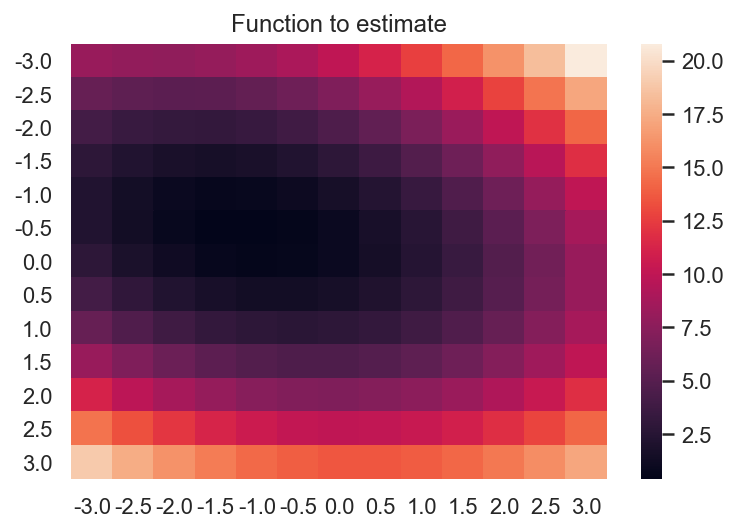

In [45]:
model = NLSystem()
[xi, yi] = np.meshgrid(np.linspace(-3, 3, 13), np.linspace(-3, 3, 13))
X = np.array([xi.ravel(), yi.ravel()]).T
assert X.shape[1] == 2
Y = model.forward(X, noise=0)

df = pd.DataFrame(Y.reshape(xi.shape), index=yi[:, 0], columns=xi[0, :])
sns.heatmap(df)
plt.title("Function to estimate")

Text(0, 0.5, 'Predicted response')

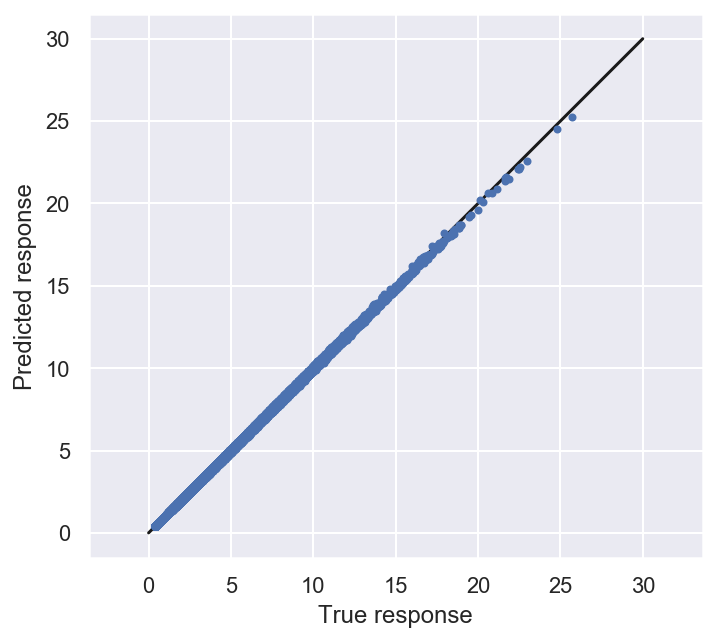

In [55]:
N = 100000
sigma = 1.0
X = sigma * np.random.randn(N, model.input_size)
Y = model.forward(X)
Y_noiseless = model.forward(X, noise=0)

class WienerSystem:
    def estimate_kernels(self, sigma, X, Y):
        N = X.shape[0]
        k_0 = Y.mean()
        res = Y - k_0
        k_1 = 1 / sigma ** 2 * X.T.dot(res) / N
        res -= X.dot(k_1)
        k_2 = (X * res.reshape((-1, 1))).T @ X / N / sigma ** 4
        k_2 /= 2
        self.k_0, self.k_1, self.k_2 = k_0, k_1, k_2
        self.sigma = sigma

    def forward(self, X):
        result = self.k_0 + X @ self.k_1 + (X * (X @ self.k_2)).sum(1) 
        result -= self.sigma ** 2 * np.diag(self.k_2).sum()
        return result

wiener = WienerSystem()
wiener.estimate_kernels(sigma, X, Y)
estimates = wiener.forward(X)

plt.figure(figsize=(5.5, 5))
plt.plot([0, 30], [0, 30], 'k-')
plt.plot(Y_noiseless, estimates, '.')
plt.axis('equal')
plt.xlabel('True response')
plt.ylabel('Predicted response')

Text(0.5, 1, 'Estimated function')

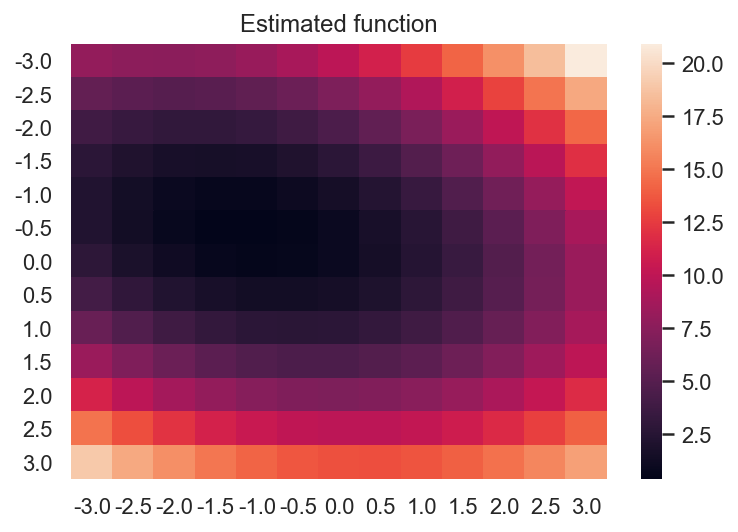

In [57]:
X = np.array([xi.ravel(), yi.ravel()]).T
assert X.shape[1] == 2
Y = wiener.forward(X)

df = pd.DataFrame(Y.reshape(xi.shape), index=yi[:, 0], columns=xi[0, :])
sns.heatmap(df)
plt.title("Estimated function")

A perfect match!